In [1]:
from brian2 import *

import plot_utils as pu

set_device('cpp_standalone', directory=None)  # Use fast "C++ standalone mode"

# Parameters

In [ ]:
################################################################################
# Model parameters
################################################################################
### General parameters
transient = 16.5*second
duration = transient + 600*ms   # Total simulation time
sim_dt = 1*ms                   # Integrator/sampling step

### Synapse parameters
rho_c = 0.005                   # Synaptic vesicle-to-extracellular space volume ratio
Y_T = 500*mmolar                # Total vesicular neurotransmitter concentration
Omega_c = 40/second             # Neurotransmitter clearance rate
U_0__star = 0.6                 # Resting synaptic release probability
Omega_f = 3.33/second           # Synaptic facilitation rate
Omega_d = 2.0/second            # Synaptic depression rate
# --- Presynaptic receptors
O_G = 1.5/umolar/second         # Agonist binding (activating) rate
Omega_G = 0.5/(60*second)       # Agonist release (deactivating) rate

### Astrocyte parameters
# ---  Calcium fluxes
O_P = 0.9*umolar/second         # Maximal Ca^2+ uptake rate by SERCAs
K_P = 0.05 * umolar             # Ca2+ affinity of SERCAs
C_T = 2*umolar                  # Total cell free Ca^2+ content
rho_A = 0.18                    # ER-to-cytoplasm volume ratio
Omega_C = 6/second              # Maximal rate of Ca^2+ release by IP_3Rs
Omega_L = 0.1/second            # Maximal rate of Ca^2+ leak from the ER
# --- IP_3R kinectics
d_1 = 0.13*umolar               # IP_3 binding affinity
d_2 = 1.05*umolar               # Ca^2+ inactivation dissociation constant
O_2 = 0.2/umolar/second         # IP_3R binding rate for Ca^2+ inhibition
d_3 = 0.9434*umolar             # IP_3 dissociation constant
d_5 = 0.08*umolar               # Ca^2+ activation dissociation constant
# --- IP_3 production
O_delta = 0.6*umolar/second     # Maximal rate of IP_3 production by PLCdelta
kappa_delta = 1.5* umolar       # Inhibition constant of PLC_delta by IP_3
K_delta = 0.1*umolar            # Ca^2+ affinity of PLCdelta
# --- IP_3 degradation
Omega_5P = 0.05/second          # Maximal rate of IP_3 degradation by IP-5P
K_D = 0.7*umolar                # Ca^2+ affinity of IP3-3K
K_3K = 1.0*umolar               # IP_3 affinity of IP_3-3K
O_3K = 4.5*umolar/second        # Maximal rate of IP_3 degradation by IP_3-3K
# --- IP_3 diffusion
F_ex = 2.0*umolar/second        # Maximal exogenous IP3 flow
I_Theta = 0.3*umolar            # Threshold gradient for IP_3 diffusion
omega_I = 0.05*umolar           # Scaling factor of diffusion
# --- Gliotransmitter release and time course
C_Theta = 0.5*umolar            # Ca^2+ threshold for exocytosis
Omega_A = 0.6/second            # Gliotransmitter recycling rate
U_A = 0.6                       # Gliotransmitter release probability
G_T = 200*mmolar                # Total vesicular gliotransmitter concentration
rho_e = 6.5e-4                  # Astrocytic vesicle-to-extracellular volume ratio
Omega_e = 60/second             # Gliotransmitter clearance rate
alpha = 0.0                     # Gliotransmission nature

################################################################################
# Model definition
################################################################################
defaultclock.dt = sim_dt  # Set the integration time

# Neuron and Synapse

In [2]:
# We are only interested in the activity of the synapse, so we replace the
# neurons by trivial "dummy" groups
spikes = [0, 50, 100, 150, 200,
          300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400]*ms
spikes += transient  # allow for some initial transient
source_neurons = SpikeGeneratorGroup(1, np.zeros(len(spikes)), spikes)
target_neurons = NeuronGroup(1, '')

### Synapses
# Note that the synapse does not actually have any effect on the post-synaptic
# target
synapses_eqs = '''
# Neurotransmitter
dY_S/dt = -Omega_c * Y_S        : mmolar (clock-driven)
# Fraction of activated presynaptic receptors
dGamma_S/dt = O_G * G_A * (1 - Gamma_S) - 
              Omega_G * Gamma_S : 1 (clock-driven)
# Usage of releasable neurotransmitter per single action potential:
du_S/dt = -Omega_f * u_S        : 1 (clock-driven)
# Fraction of synaptic neurotransmitter resources available:
dx_S/dt = Omega_d *(1 - x_S)    : 1 (clock-driven)
# released synaptic neurotransmitter resources:
r_S                             : 1
# gliotransmitter concentration in the extracellular space:
G_A                             : mmolar
'''
synapses_action = '''
U_0 = (1 - Gamma_S) * U_0__star + alpha * Gamma_S
u_S += U_0 * (1 - u_S)
r_S = u_S * x_S
x_S -= r_S
Y_S += rho_c * Y_T * r_S
'''
synapses = Synapses(source_neurons, target_neurons,
                    model=synapses_eqs, on_pre=synapses_action,
                    method='linear')
# We create three synapses, only the second and third ones are modulated by astrocytes
synapses.connect(True, n=3)

In [3]:

### Astrocytes
# The astrocyte emits gliotransmitter when its Ca^2+ concentration crosses
# a threshold
astro_eqs = '''
# IP_3 dynamics:
dI/dt = J_delta - J_3K - J_5P + J_ex                             : mmolar
J_delta = O_delta/(1 + I/kappa_delta) * C**2/(C**2 + K_delta**2) : mmolar/second
J_3K = O_3K * C**4/(C**4 + K_D**4) * I/(I + K_3K)                : mmolar/second
J_5P = Omega_5P*I                                                : mmolar/second
# Exogenous stimulation
delta_I_bias = I - I_bias          : mmolar
J_ex = -F_ex/2*(1 + tanh((abs(delta_I_bias) - I_Theta)/omega_I)) *
                sign(delta_I_bias) : mmolar/second
I_bias                             : mmolar (constant)

# Ca^2+-induced Ca^2+ release:
dC/dt = (Omega_C * m_inf**3 * h**3 + Omega_L) * (C_T - (1 + rho_A)*C) -
        O_P * C**2/(C**2 + K_P**2) : mmolar
dh/dt = (h_inf - h)/tau_h : 1  # IP3R de-inactivation probability
m_inf = I/(I + d_1) * C/(C + d_5)  : 1
h_inf = Q_2/(Q_2 + C)              : 1
tau_h = 1/(O_2 * (Q_2 + C))        : second
Q_2 = d_2 * (I + d_1)/(I + d_3)    : mmolar
# Fraction of gliotransmitter resources available:
dx_A/dt = Omega_A * (1 - x_A)      : 1
# gliotransmitter concentration in the extracellular space:
dG_A/dt = -Omega_e*G_A             : mmolar
'''
glio_release = '''
G_A += rho_e * G_T * U_A * x_A
x_A -= U_A *  x_A
'''

# Effect of GlioTransmitter on Synapse

In [4]:

# The gliotransmitter release happens when the threshold is crossed, in Brian
# terms it can therefore be considered a "reset"
astrocyte = NeuronGroup(2, astro_eqs,
                        threshold='C>C_Theta',
                        refractory='C>C_Theta',
                        reset=glio_release,
                        method='rk4')
# Different length of stimulation
astrocyte.x_A = 1.0
astrocyte.h = 0.9
astrocyte.I = 0.4*umolar
astrocyte.I_bias = np.asarray([0.8, 1.25])*umolar

# several astrocytes
ecs_astro_to_syn = Synapses(astrocyte, synapses,
                            'G_A_post = G_A_pre : mmolar (summed)')
ecs_astro_to_syn.connect(j='i+1')

WARNING    Cannot check whether the indices to record from are valid. This can happen in standalone mode when recording from synapses that have been created with a connection pattern. You can avoid this situation by using synaptic indices in the connect call. [brian2.monitors.statemonitor.cannot_check_statemonitor_indices]


Starting simulation at t=0 s for duration 17.1 s
17.1 s (100%) simulated in < 1s


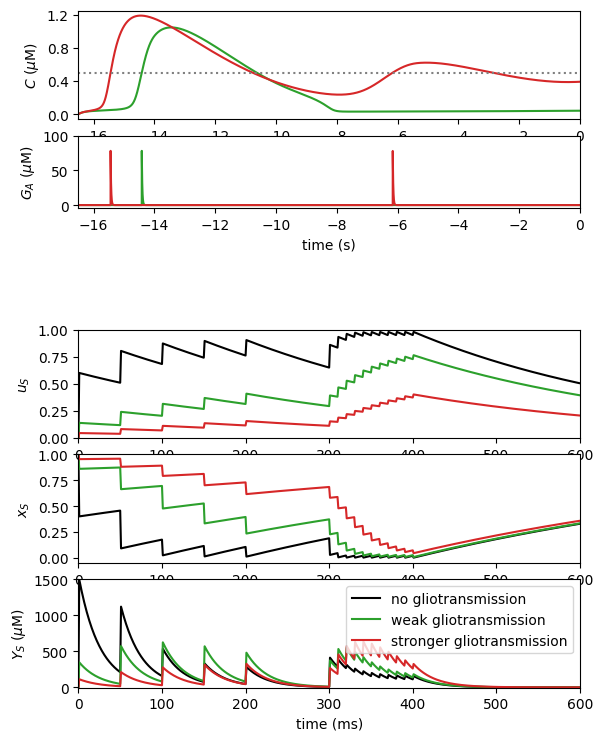

In [5]:

# Monitors

syn_mon = StateMonitor(synapses, variables=['u_S', 'x_S', 'r_S', 'Y_S'],
                       record=[0, 1, 2])
ast_mon = StateMonitor(astrocyte, variables=['C', 'G_A'], record=True)

run(duration, report='text')

# Plotting
from matplotlib import cycler

fig, ax = plt.subplots(nrows=7, ncols=1,figsize=(6.26894, 6.26894 * 1.2),
                       gridspec_kw={'height_ratios': [3, 2, 1, 1, 3, 3, 3],
                                    'top': 0.98, 'bottom': 0.08,
                                    'left': 0.15, 'right': 0.95})

## Ca^2+ traces of the two astrocytes
ax[0].plot((ast_mon.t-transient)/second, ast_mon.C[0]/umolar, '-', color='C2')
ax[0].plot((ast_mon.t-transient)/second, ast_mon.C[1]/umolar, '-', color='C3')
## Add threshold for gliotransmitter release
ax[0].plot(np.asarray([-transient/second,0.0]),
           np.asarray([C_Theta,C_Theta])/umolar, ':', color='gray')
ax[0].set(xlim=[-transient/second, 0.0], yticks=[0., 0.4, 0.8, 1.2],
          ylabel=r'$C$ ($\mu$M)')

## Gliotransmitter concentration in the extracellular space
ax[1].plot((ast_mon.t-transient)/second, ast_mon.G_A[0]/umolar, '-', color='C2')
ax[1].plot((ast_mon.t-transient)/second, ast_mon.G_A[1]/umolar, '-', color='C3')
ax[1].set(yticks=[0., 50., 100.], xlim=[-transient/second, 0.0],
          xlabel='time (s)', ylabel=r'$G_A$ ($\mu$M)')

## Turn off one axis to display x-labeling of ax[1] correctly
ax[2].axis('off')

ax[3].axis('off')

## Synaptic variables
# Use a custom cycle that uses black as the first color
prop_cycle = cycler(color='k').concat(matplotlib.rcParams['axes.prop_cycle'][2:])
ax[4].set(xlim=(0, (duration-transient)/ms), ylim=[0., 1.],
          yticks=np.arange(0, 1.1, .25), ylabel='$u_S$',
          prop_cycle=prop_cycle)
ax[4].plot((syn_mon.t-transient)/ms, syn_mon.u_S.T)

ax[5].set(xlim=(0, (duration-transient)/ms), ylim=[-0.05, 1.],
          yticks=np.arange(0,1.1,.25), ylabel='$x_S$',
          prop_cycle=prop_cycle)
ax[5].plot((syn_mon.t-transient)/ms, syn_mon.x_S.T)

ax[6].set(xlim=(0, (duration-transient)/ms), ylim=(-5., 1500),
          xticks=np.arange(0, (duration-transient)/ms, 100), xlabel='time (ms)',
          yticks=[0, 500, 1000, 1500], ylabel=r'$Y_S$ ($\mu$M)',
          prop_cycle=prop_cycle)
ax[6].plot((syn_mon.t-transient)/ms, syn_mon.Y_S.T/umolar)
ax[6].legend(['no gliotransmission',
              'weak gliotransmission',
              'stronger gliotransmission'], loc='upper right')


plt.show()